# Plot Burden and Forcing Maps for Paper

The notebook create global maps of
* burden
* middle atmoshpere shortwave & longwave forcing

It reads timemean data for nudged and ensemble simulation and all different fire scalings.

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import cartopy.crs as ccrs
import importlib

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )

import string

In [3]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

*Data Description*:

* ensembles are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_gfas2020_injtrp+1_pcb_ao_ens`
    * ensemble data two subdirs as hierachical structure
    
* nudged data are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_nu_gfas2020_injtrp+1_pcb_ao`


In [4]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )
from analysis import ens_stat


In [5]:
if True:  # large original data
    
    burden = reader.read_wifiaus_combination( file_type = 'burden', average_type = 'tmean' )
    echam = reader.read_wifiaus_combination( file_type = 'echam', average_type = 'tmean' )

    dset = echam
    dset['burden_BC'] = burden['burden_BC']

    F_sw_MA = dset['srad0'] - dset['sradl']
    F_sw_MA.attrs['long_name'] = 'solar radiation absorb. in middle atm.'

    dset['F_sw_MA'] = F_sw_MA


    F_lw_MA = dset['trad0'] - dset['tradl']
    F_lw_MA.attrs['long_name'] = 'terrestrial radiation absorb. in middle atm.'

    dset['F_lw_MA'] = F_lw_MA


In [6]:
if False: # small pp data
    input_dir = '/work/bb1262/work_archive/bm0834/data/wifi-aus/statistics/'

    dset = xr.open_dataset( f'{input_dir}/burden-and-forcings-for.maps.nc' )
    dset.load()

## Plotting 

In [7]:
def map_plotter(v, vmin = -3e-7, vmax = 3e-7, mode = 'fire1.0', proj = ccrs.Robinson(central_longitude=180),
                relative = False,
                ioffset = 0, cmap = plt.cm.RdBu_r, bartext = 'BC Burden / (kg m${}^{-2}$)'):

    v_ens_all = ens_stat( v )
    
    v_ens = v_ens_all.sel( mode = mode)
    v_nudged = v.sel( ensemble = 'nudged' )
    dv_nudged = v_nudged.sel( mode = mode) - v_nudged.sel( mode = 'fire0.0')
    
    if relative:
        dv_nudged = 100. * dv_nudged / v_nudged.sel( mode = 'fire0.0')
    
    fig, axs = plt.subplots(figsize = (20, 7), ncols = len( v.time ), nrows = 2, subplot_kw = dict(projection=proj),  )
    plt.subplots_adjust( left = 0.2, right = 0.9, hspace = 0.2, wspace = 0.1)
    # nudged
    i = 0
    iabc = ioffset
    for time in v.time:
        a = axs[0,i]
        p = dv_nudged.sel(time = time).plot(
            vmin = vmin, vmax = vmax,
            add_colorbar = False,
            cmap = cmap,
            ax = a, transform=ccrs.PlateCarree(),)
                    
     #   a.set_title('(%s)' % string.ascii_lowercase[iabc])
        a.set_title('(%s) %s' % (string.ascii_lowercase[iabc], str(time.data)[:7]))
            
        #p.set_global()
        a.coastlines()  
        
        i += 1
        iabc += 1
        
        
    i = 0
    for time in v.time:
        a = axs[1,i]
        vmean = v_ens.sel(time = time, stats = 'mean')
        vconf = v_ens.sel(time = time, stats = 'confidence')
        vref  = v_ens.sel(time = time, stats = 'reference',) 
        
        sigma = np.abs( vmean / vconf )
        
        if relative:
            vmean = 100*vmean / vref

        p = vmean.plot(
            vmin = vmin, vmax = vmax,
            add_colorbar = False,
            cmap = cmap,
            ax = a, transform=ccrs.PlateCarree(),)
        
        if i == 0:
            axc = fig.add_axes( [0.92, 0.2, 0.01, 0.6] ) 
            plt.colorbar(p, axc)
            plt.figtext( 0.97, 0.5, bartext,  rotation = 90, va = 'center', ha = 'center', fontsize = 'x-large' )

        sigma.where(sigma > 1).plot.contourf( 
            ax = a,
            levels = [0, 1000],
            add_colorbar = False,
            transform=ccrs.PlateCarree(),
            colors='none', 
            hatches = ['//'])

        a.set_title('(%s) %s' % (string.ascii_lowercase[iabc], str(time.data)[:7]))
            
        #p.set_global()
        a.coastlines()  
        
        i += 1
        iabc += 1
        
    fkws = dict(ha = 'right', fontsize = 20, fontweight = 'bold')
    plt.figtext(0.18, 0.7, 'nudged', **fkws)
    plt.figtext(0.18, 0.3, 'ensemble', **fkws)
    plt.figtext(0.55, 0.95, bartext, ha = 'center', fontsize = 24, fontweight = 'bold' )
    
    return 

        

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/

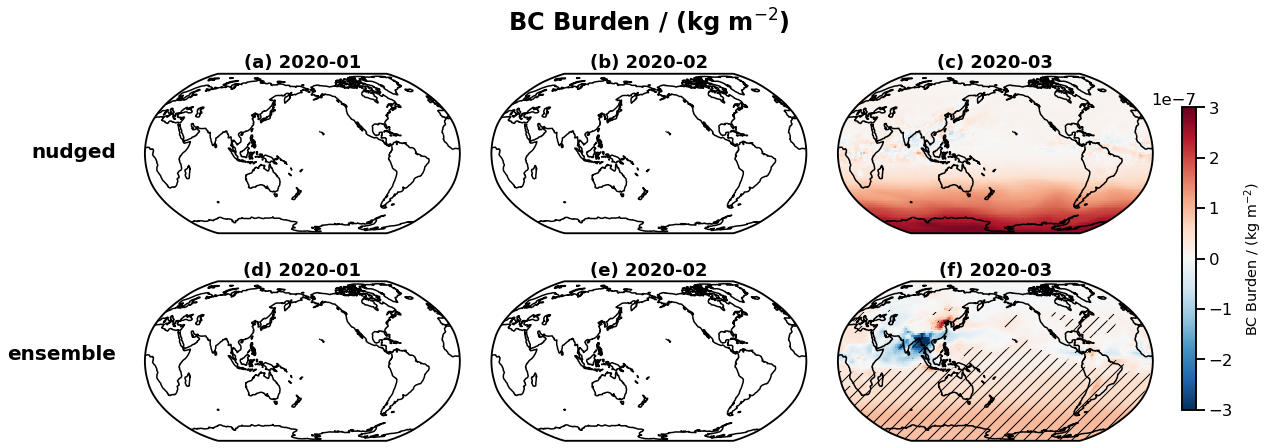

In [8]:
map_plotter( dset['burden_BC'] )
plt.savefig('../pics/burden-maps.png', dpi = 600)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


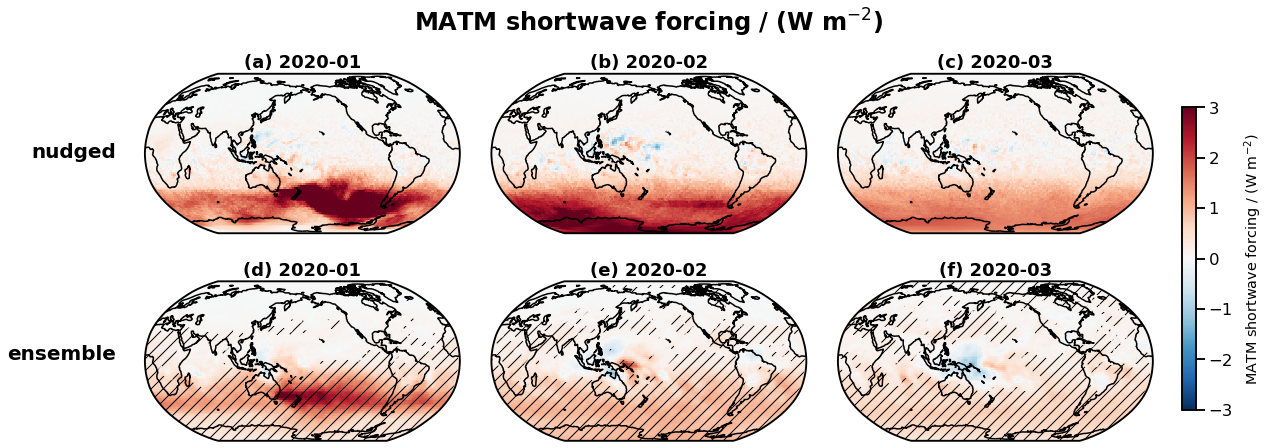

In [9]:
kws = dict( vmin = -3, vmax = 3, ioffset = 0, bartext = 'MATM shortwave forcing / (W m${}^{-2}$)' )
map_plotter( dset['F_sw_MA'], **kws )
plt.savefig('../pics/sw-ma-forcing-maps.png', dpi = 600)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


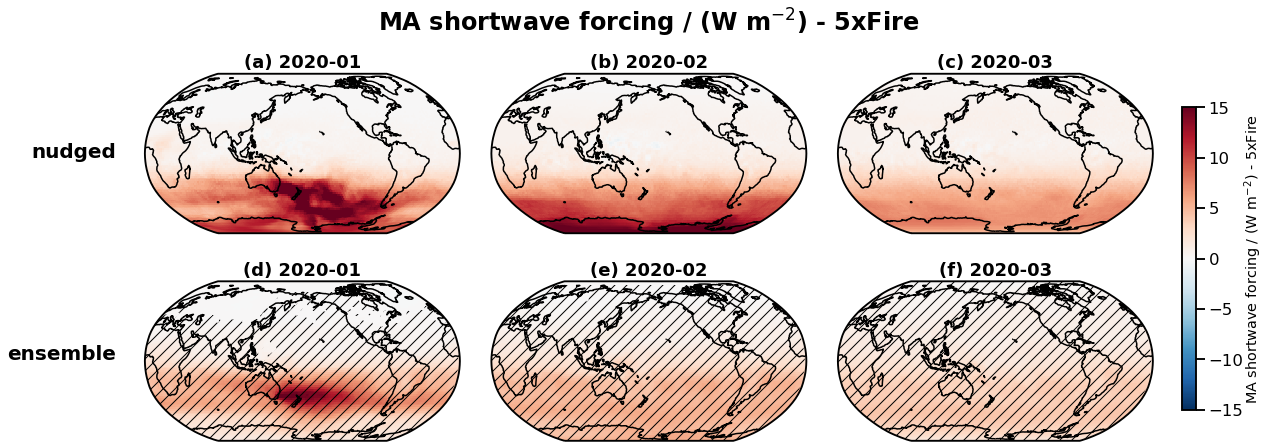

In [10]:
kws = dict( vmin = -3*5, vmax = 3*5, ioffset = 0, mode = 'fire5.0',
            bartext = 'MA shortwave forcing / (W m${}^{-2}$) - 5xFire' )
map_plotter( dset['F_sw_MA'], **kws )


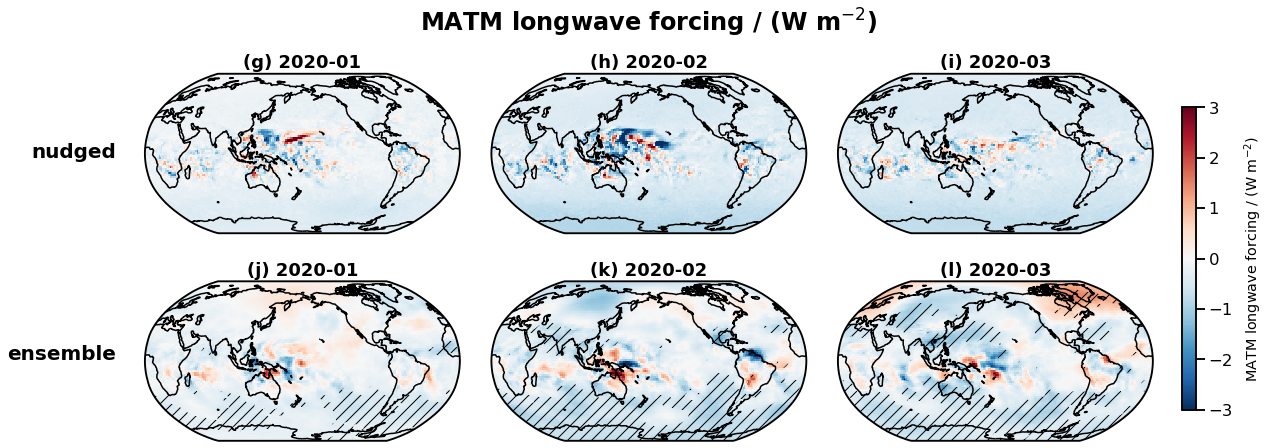

In [11]:
kws = dict( vmin = -3, vmax = 3, ioffset = 6, bartext = 'MATM longwave forcing / (W m${}^{-2}$)' )
map_plotter( dset['F_lw_MA'], **kws )
plt.savefig('../pics/lw-ma-forcing-maps.png', dpi = 600)

**Take-away points:**

* Australian smoke leads to significant positive shortwave forcing in the stratosphere.
* SW forcing is larger when actual meterological situation during wild events is considered. It is also plausible that smoke-induced synopic-scale vortex structures are efficient to keep the smoke bubble intact and in a rather confined shape.
* Stratospheric thermal structure adjusts such that a negative longwave response balances a significant portion of the shortwave forcing. The longwave response is most significant in the region where the smoke-radiation interaction happens. 


In [12]:
lw = dset['F_lw_MA']

In [13]:
lw

,Array,Chunk
Bytes,39.02 MiB,72.00 kiB
Shape,"(5, 37, 3, 96, 192)","(1, 1, 1, 96, 192)"
Count,23539 Tasks,555 Chunks
Type,float32,numpy.ndarray


In [14]:
lw_ens = ens_stat( lw ).sel(stats = 'mean') 

In [15]:
lw_nudged = lw.sel( mode = lw_ens.mode, ensemble = 'nudged' ) - lw.sel( mode = 'fire0.0', ensemble = 'nudged' )

In [16]:
both_agree = lw_ens * lw_nudged
thresh = -0.2
both_agree = both_agree.where( np.logical_and( lw_ens < thresh, lw_nudged < thresh ) )

both_agree.load()

<xarray.DataArray 'F_lw_MA' (mode: 4, time: 3, lat: 96, lon: 192)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [ 0.07321908,  0.07137579,  0.07016981, ...,  0.07199658,
           0.07318267,  0.07400391],
         [ 0.08015058,  0.07927684,  0.07836484, ...,  0.07862132,
           0.07902362,  0.07996194],
         [ 0.07519665,  0.07473306,  0.07457438, ...,  0.0766113 ,
           0.07605422,  0.07550244]],

        [[ 0.21909113,  0.21671905,  0.22302409, ...,  0.22044536,
           0.22085336,  0.22133924],
         [ 0.20782517,  0.21360485,  0.21170531, ...,  0.20049742,
           0.20094198,  0.20283285],
         [ 0.1892724 ,  0.20157556,  0.20859775, ...,  0.18392856,
           0.18476251,  0.1847778 ],
...
         [16.135273  , 16.111282  , 16.04635   , ..., 16.094454  ,
          16.110111  , 16.162704  ],
         [16.300053  , 16.3306    , 16.323736  , ..., 16.21734   ,
          16.24992   , 16.272076  ],
         [16.518892  , 16.51106   , 16.51427   , ..., 16.522675  ,
          16.52236   , 16.517233  ]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [11.484703  , 11.482117  , 11.47931   , ..., 11.489854  ,
          11.484302  , 11.494525  ],
         [11.436453  , 11.437417  , 11.46937   , ..., 11.427996  ,
          11.420654  , 11.419308  ],
         [11.552457  , 11.537019  , 11.54373   , ..., 11.552935  ,
          11.551534  , 11.548197  ]]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-16T14:52:30 ... 2020-03-16T11:52:30
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat       (lat) float64 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * mode      (mode) <U7 'fire1.0' 'fire2.0' 'fire3.0' 'fire5.0'
    stats     <U10 'mean'
    ensemble  <U11 'nudged'
Attributes:
    long_name:      terrestrial radiation absorb. in middle atm.
    units:          W/m**2
    code:           179
    table:          128
    CDI_grid_type:  gaussian
    cell_methods:   time: mean

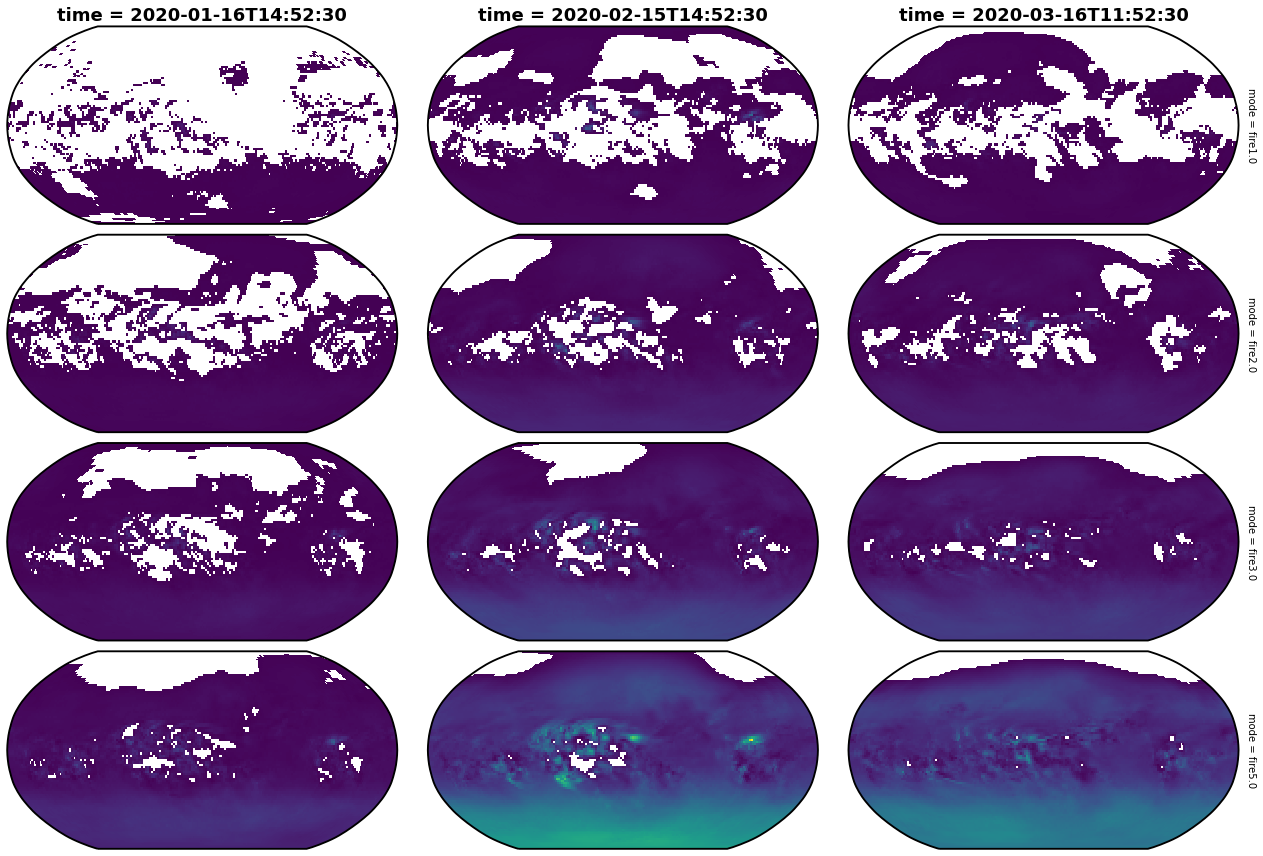

In [17]:
both_agree.plot( col = 'time', row = 'mode',
                add_colorbar = False,
                subplot_kws = dict( projection = ccrs.Robinson(central_longitude=180)),
                figsize = (18,12),
                transform=ccrs.PlateCarree(),)